My DLS 2024 Finals Solution for Problem F. Удалить вотермарку. Preprocessing was pretty simple with no rotations and color switches for augmentation. Then an AutoEncoder module with a bottleneck, which helps to remove a watermark. I was using MAE metric and trained for only 10 epochs.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
!unzip data_generation.zip

Archive:  data_generation.zip
  inflating: baseline_generation.ipynb  
  inflating: sample_submission_generation.npy  
  inflating: test_corrupted_images.npy  
  inflating: train_corrupted_images.npy  
  inflating: train_true_images.npy   


In [3]:
class PairedWatermarkDataset(Dataset):
    def __init__(self, watermarked_path, clean_path, transform=None):
        with open(clean_path, "rb") as f:
            self.clean = np.load(f).astype(int)
        with open(watermarked_path, "rb") as f:
            self.watermarked = np.load(f).astype(int)
        self.transform = transform

        assert len(self.watermarked) == len(self.clean), "Количество изображений не совпадает"

    def __len__(self):
        return len(self.watermarked)

    def __getitem__(self, idx):
        img_w = self.watermarked[idx]
        img_c = self.clean[idx]

        img_w = torch.from_numpy(img_w).float().permute(2, 0, 1)
        img_c = torch.from_numpy(img_c).float().permute(2, 0, 1)

        if img_w.max() > 1.0:
            img_w = img_w / 255.0
        if img_c.max() > 1.0:
            img_c = img_c / 255.0

        if self.transform:
            img_w = self.transform(img_w)

            img_c = self.transform(img_c)


        return img_w, img_c


train_dataset = PairedWatermarkDataset(
    'train_corrupted_images.npy',
    'train_true_images.npy',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
    ])
)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = F.relu(x + residual)
        return x

class MyModel(nn.Module):
    def __init__(self, in_channels=3):
        super(MyModel, self).__init__()

        self.enc_conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_res1 = ResidualBlock(64)
        self.enc_pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_res2 = ResidualBlock(128)
        self.enc_pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_res3 = ResidualBlock(256)
        self.enc_pool3 = nn.MaxPool2d(2)


        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ResidualBlock(512),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.dec_res1 = ResidualBlock(256)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = nn.Conv2d(384, 128, 3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_res2 = ResidualBlock(128)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv3 = nn.Conv2d(192, 64, 3, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(64)
        self.dec_res3 = ResidualBlock(64)

        self.final_conv = nn.Conv2d(64, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Encoder with skip connections
        e1 = F.relu(self.enc_bn1(self.enc_conv1(x)))
        e1 = self.enc_res1(e1)
        p1 = self.enc_pool1(e1)

        e2 = F.relu(self.enc_bn2(self.enc_conv2(p1)))
        e2 = self.enc_res2(e2)
        p2 = self.enc_pool2(e2)

        e3 = F.relu(self.enc_bn3(self.enc_conv3(p2)))
        e3 = self.enc_res3(e3)
        p3 = self.enc_pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with skip connections
        d1 = self.up1(b)
        d1 = torch.cat([d1, e3], dim=1)  # Skip connection
        d1 = F.relu(self.dec_bn1(self.dec_conv1(d1)))
        d1 = self.dec_res1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)  # Skip connection
        d2 = F.relu(self.dec_bn2(self.dec_conv2(d2)))
        d2 = self.dec_res2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)  # Skip connection
        d3 = F.relu(self.dec_bn3(self.dec_conv3(d3)))
        d3 = self.dec_res3(d3)

        out = self.sigmoid(self.final_conv(d3))
        return out

In [36]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder
        self.encoders = nn.ModuleList()
        self.pools = nn.ModuleList()

        for feature in features:
            self.encoders.append(DoubleConv(in_channels, feature))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        self.up_convs = nn.ModuleList()
        self.decoders = nn.ModuleList()

        for feature in reversed(features):
            self.up_convs.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoders.append(
                DoubleConv(feature*2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder, pool in zip(self.encoders, self.pools):
            x = encoder(x)
            skip_connections.append(x)
            x = pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]

        for idx, (up_conv, decoder) in enumerate(zip(self.up_convs, self.decoders)):
            x = up_conv(x)
            skip = skip_connections[idx]

            # Handle size mismatch
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)

            x = torch.cat([skip, x], dim=1)
            x = decoder(x)

        return self.sigmoid(self.final_conv(x))

In [38]:
def train_epoch(model, train_loader, criterion, opt, epoch, device):
    epoch_loss = []
    model.train()

    for watermarked, clean in train_loader:
        watermarked, clean = watermarked.to(device, non_blocking=True), clean.to(device, non_blocking=True)

        y_pred = model(watermarked) # (4, 3, 128, 128)
        loss = criterion(clean, y_pred)
        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_loss.append(loss.item())

    print(f'{epoch=}')
    print('TRAIN LOSS', np.mean(epoch_loss))
    return np.mean(epoch_loss)


def validate_epoch(model, val_loader, criterion, epoch, device):
    epoch_loss = []
    model.eval()

    with torch.no_grad():
        for watermarked, clean in val_loader:
            watermarked, clean = watermarked.to(device), clean.to(device)

            y_pred = model(watermarked)
            loss = criterion(clean, y_pred)

            epoch_loss.append(loss.item())

    print(f'{epoch=}')
    print('VAL LOSS', np.mean(epoch_loss))
    return np.mean(epoch_loss)

In [39]:
criterion = nn.L1Loss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []
for epoch in range(10):
    print('Starting epoch', epoch + 1)
    train_epoch_loss = train_epoch(model, train_loader, criterion, opt, epoch, device)
    train_losses.append(train_epoch_loss)


Starting epoch 1
epoch=0
TRAIN LOSS 1.8318917197585105
Starting epoch 2
epoch=1
TRAIN LOSS 1.7311955282092095
Starting epoch 3
epoch=2
TRAIN LOSS 1.71272561866045
Starting epoch 4
epoch=3
TRAIN LOSS 1.7054667876958847
Starting epoch 5
epoch=4
TRAIN LOSS 1.701738442182541
Starting epoch 6
epoch=5
TRAIN LOSS 1.6989145084023476
Starting epoch 7
epoch=6
TRAIN LOSS 1.6969764090180397
Starting epoch 8
epoch=7
TRAIN LOSS 1.6958210159540177
Starting epoch 9
epoch=8
TRAIN LOSS 1.6941412138342857
Starting epoch 10
epoch=9
TRAIN LOSS 1.6927986624836922


In [40]:
with open('test_corrupted_images.npy', 'rb') as f:
    test = np.load(f).astype(int)


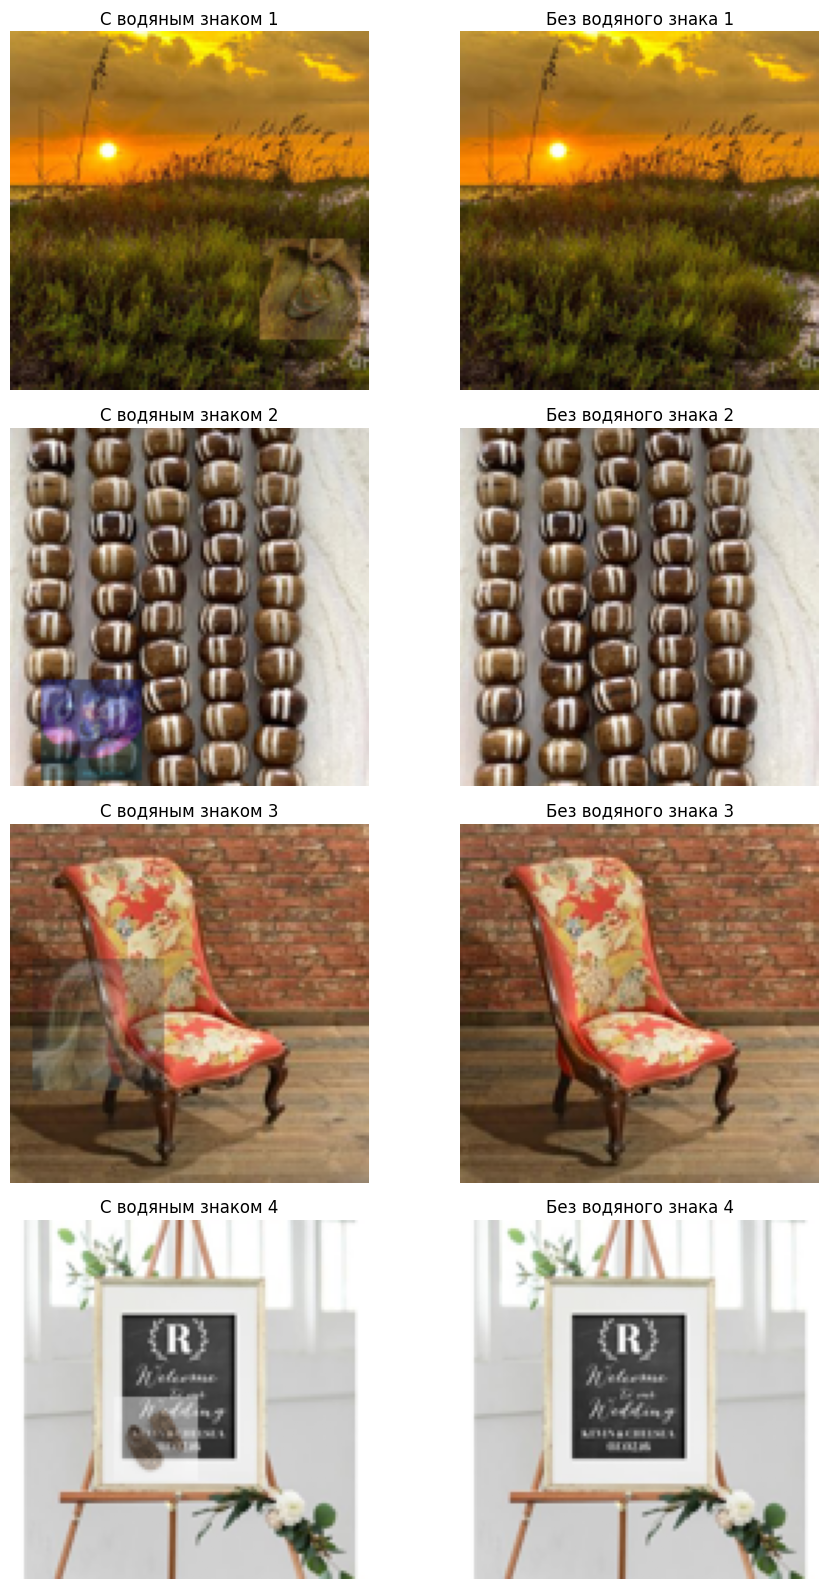

In [7]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)  # Обрезаем значения в [0, 1]
    return tensor


iterator = iter(train_loader)
with torch.no_grad():
    watermarked, clean = next(iterator)

    fig, axes = plt.subplots(4, 3, figsize=(10, 16))

    for i in range(4):
        wat_one = watermarked[i]
        clean_one = clean[i]
        model_one = model(wat_one.unsqueeze(0)).squeeze(0).cpu()

        wat_denorm = denormalize(wat_one,
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        clean_denorm = denormalize(clean_one,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

        model_denorm = denormalize(model_one,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

        wat_display = wat_denorm.cpu().permute(1, 2, 0).numpy()
        clean_display = clean_denorm.cpu().permute(1, 2, 0).numpy()
        model_display = model_denorm.cpu().permute(1, 2, 0).numpy()


        axes[i, 0].imshow(wat_display)
        axes[i, 0].set_title(f'С водяным знаком {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(clean_display)
        axes[i, 1].set_title(f'Без водяного знака {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(model_display)
        axes[i, 2].set_title(f'Предсказание модели {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [55]:
with torch.no_grad():
  plt.imshow(model(next(iterator)))

ValueError: expected 4D input (got 3D input)